###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2019 Daniel Koehn based on (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

In [1]:
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, 'r').read())

# 1D Linear Advection Problem: Numerical Diffusion

In the last lesson, we could compute accurate solutions for the 1D linear advection equation using the Forward-Time-Backward-Space FD method (FTBS method), if we use an apropriate spatial grid spacing $\Delta x$ and satisfy the CFL-conditon in order to avoid an instability of the numerical solution.

However, beside the stability of the FD solution another problem arises when advecting the solution over larger distances. Let 's take a closer look at the problem ...

## FTBS Method

Before we begin, I shortly review the numerical method, we used so far to solve the *one-dimensional linear advection equation*

$$
\begin{equation}
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 \tag{1}
\end{equation}
$$

We implemented **Euler's method** by using a forward-difference scheme for the time derivative. For the spatial derivatives a backward-difference scheme was choosen, resulting in the forward in time & backward in space **FTBS Method**, reading in 
discrete form as:

$$
\begin{equation}
\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_i^n - u_{i-1}^n}{\Delta x} = 0 \notag
\end{equation}
$$

where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. With given initial conditions, the only unknown in this discretization is $u_i^{n+1}$.  We solve for this unknown to get an equation that lets us step in time, as follows:

$$
\begin{equation}
u_i^{n+1} = u_i^n - c \frac{\Delta t}{\Delta x}(u_i^n-u_{i-1}^n) \notag
\end{equation}
$$

To ensure the stability of the numerical solution, we have to choose a time step $\Delta t$ satisfying the Courant-Friedrichs-Lewy (CFL) criterion:

\begin{equation}
\Delta t \le \frac{\sigma \Delta x}{c} \notag
\end{equation}

depending on the spatial gridpoint distance $\Delta x$, advection velocity $c$ and a factor $\sigma$.

Below, you find the same code, we used in the previous notebook, I only extended the spatial computational domain from $L=2$ to $L=15$ and added the analytical solution

$$
\begin{equation}
u(x,t)=u_0(x-ct) \notag
\end{equation}
$$

with the initial condition $u(x,0)=u_0(x)$ to verify the accuracy of the numerical solution.

In [2]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
def linear_advection_FTBS(nx, Tmax, L=15.0, c=1.0, sigma=0.5):
    """
    Solves the 1D linear advection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    Tmax : float
        Maximum integration time
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Advection speed; default: 1.0.
    sigma : float, optional
        CFL constraint; default: 0.5.
    dt : float, optional
        Time-step size; default: 0.025.
    nt : integer, optional
        Number of time steps to compute; default: 20.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Compute the time-step size based on the CFL constraint.
    dt = sigma * dx / c
    
    # Compute number of time steps
    nt = (int)(Tmax/dt)
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Define analytical solution
    ua = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5 + c*Tmax, x <= 1.0 + c*Tmax))
    ua[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx):
            # Solving the advection problem using the FTBS method
            u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
        
    # Plot the solution along with the initial conditions and analytical solution
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.plot(x, ua, label='Analytical',
                color='C2', linestyle='--', linewidth=2)
    pyplot.legend(loc="lower left")
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

Let's examine the results of the linear advection problem using $nx=2000$ spatial gridpoints and a maximum propagation time $T_{max}=0.5$:

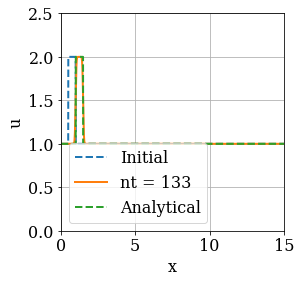

In [5]:
# Define maximum time Tmax
Tmax = 0.5
linear_advection_FTBS(2000,Tmax)

As you can see, the numerical solution coincides very well with the analytical solution. What happens if we increase the maximum modelling time from $T_{max}=0.5$ to $T_{max}=13$?

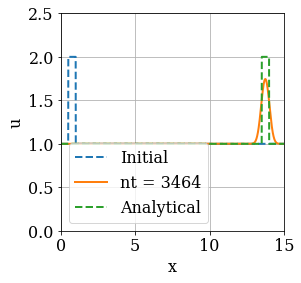

In [6]:
# Define maximum time Tmax
Tmax = 13.
linear_advection_FTBS(2000,Tmax)

Unfortunately, for $T_{max}=13$ the numerical solution is not accurate anymore. The amplitude of the initial rectangle function is decreased and the function in general significantly smoothed. 

As we will see in the next class, this solution is similar to the one we can achieve for the diffusion problem. However, in case of the advection problem, this behaviour is purely artifical and denoted as **Numerical Diffusion**. In the following exercises, you will implement and test different alternative FD methods in order to mitigate the effect of numerical diffusion.

## FTCS Method

The first idea might be that the numerical diffusion might be related to the low accuray of the backward-difference scheme for the space derivative. As we have seen in the first lesson of this lecture the central-difference scheme for the space derivative

$$
\begin{equation}
\frac{\partial u}{\partial x} \approx \frac{u(x_{i+1})-u(x_{i-1})}{2\Delta x} \quad\text{Central}\notag
\end{equation}
$$

is more accurate than the backward-difference scheme. So let's implement an Euler method using a forward-difference scheme for the time derivative and choose the central-difference scheme for the space derivative, called forward in time & central in space **FTCS Method**. Our discrete equation is then:

$$
\begin{equation}
\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} = 0 \notag
\end{equation}
$$

where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. With given initial conditions, the only unknown in this discretization is $u_i^{n+1}$.  We solve for this unknown to get an equation that lets us step in time, as follows:

$$
\begin{equation}
u_i^{n+1} = u_i^n - c \frac{\Delta t}{2\Delta x}(u_{i+1}^n-u_{i-1}^n) \tag{2}
\end{equation}
$$

##### Exercise 1

Replace the FTBS method in the code below by the FTCS method eq.(2). Run the FTCS-code for
$T_{max} = 13$, describe and compare the results with the one from the FTBS code.

In [ ]:
def linear_advection_FTCS(nx, Tmax, L=15.0, c=1.0, sigma=0.5):
    """
    Solves the 1D linear advection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    Tmax : float
        Maximum integration time
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Advection speed; default: 1.0.
    sigma : float, optional
        CFL constraint; default: 0.5.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Compute the time-step size based on the CFL constraint.
    dt = sigma * dx / c
    
    # Compute number of time steps
    nt = (int)(Tmax/dt)
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Define analytical solution
    ua = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5 + c*Tmax, x <= 1.0 + c*Tmax))
    ua[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx-1):
            
            # REPLACE THE SPATIAL BACKWARD-FD OPERATOR FROM THE FTBS-SCHEME ...
            #u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
        
            # ... BY THE FTCS-SCHEME
            u[i] = 
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.plot(x, ua, label='Analytical',
                color='C2', linestyle='--', linewidth=2)
    pyplot.legend(loc="lower left")
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

In [ ]:
# Define maximum time Tmax
Tmax = 13.
linear_advection_FTCS(2000,Tmax)

## Lax-Friedrichs Method

As you have seen, the **FTCS Method** seem to be quite unstable, even when you decrease the factor $\sigma$. Actually, it is unconditionally unstable, meaning that you can not estimate a time step $\Delta t$ to estimate any accurate solution, as can be proven by the [von Neumann Stability Analysis](https://de.wikipedia.org/wiki/Von-Neumann-Stabilit%C3%A4tsanalyse). While the spatial central FD operator is more accurate than the spatial backward operator, it introduces an artifical **negative diffusion**, which amplifies amplitudes instead of damping them in any physics based diffusion problem. The negative diffusion subsequently leads to the instability of the FTCS code.

So, is there a possibility to stabilize the FTCS method? Some day, two guys [Peter Lax](https://en.wikipedia.org/wiki/Peter_Lax) and [Kurt Friedrichs](https://en.wikipedia.org/wiki/Kurt_Otto_Friedrichs) thought: well let's replace the $u_i^n$ in the time derivative of the FTCS method:

$$
\begin{equation}
\frac{u_i^{n+1}-u_i^n}{\Delta t} + c \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} = 0 \notag
\end{equation}
$$

by the spatial average of the neighbouring grid points

$u_i^n = (u_{i+1}^n+u_{i-1}^n)/2$ 

leading to

$$
\begin{equation}
\frac{u_i^{n+1}-(u_{i+1}^n+u_{i-1}^n)/2}{\Delta t} + c \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} = 0 \notag
\end{equation}
$$

where $n$ and $n+1$ are two consecutive steps in time, while $i-1$ and $i$ are two neighboring points of the discretized $x$ coordinate. With given initial conditions, the only unknown in this discretization is $u_i^{n+1}$.  We solve for this unknown to get an equation that lets us step in time, as follows:

$$
\begin{equation}
u_i^{n+1} = \frac{(u_{i+1}^n+u_{i-1}^n)}{2} - c \frac{\Delta t}{2\Delta x}(u_{i+1}^n-u_{i-1}^n) \tag{3}
\end{equation}
$$

##### Exercise 2

Replace the FTBS method in the code below by the Lax-Friedrichs method eq. (3). Run the Lax-Friedrichs code for $T_{max} = 13$. Describe and compare the results with the one from the FTCS code.

In [ ]:
def linear_advection_Lax(nx, Tmax, L=15.0, c=1.0, sigma=0.5):
    """
    Solves the 1D linear advection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    Tmax : float
        Maximum integration time
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Advection speed; default: 1.0.
    sigma : float, optional
        CFL constraint; default: 0.5.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Compute the time-step size based on the CFL constraint.
    dt = sigma * dx / c
    
    # Compute number of time steps
    nt = (int)(Tmax/dt)
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Define analytical solution
    ua = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5 + c*Tmax, x <= 1.0 + c*Tmax))
    ua[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx-1):
            # REPLACE THE SPATIAL BACKWARD-FD OPERATOR FROM THE FTBS-SCHEME ...
            #u[i] = un[i] - c * dt / dx * (un[i] - un[i - 1])
        
            # ... BY THE LAX-FRIEDRICHS-SCHEME
            u[i] = 
        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x, u, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.plot(x, ua, label='Analytical',
                color='C2', linestyle='--', linewidth=2)
    pyplot.legend(loc="lower left")
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

In [ ]:
# Define maximum time Tmax
Tmax = 13.
linear_advection_Lax(2000,Tmax)

## Marker-in-Cell Method

Wow, the numerical diffusion in the Lax-Friedrichs approach seems to be even worse than in the original FTBS scheme. An accurate solution of the "simple" 1D advection seem to be a quite challenging task. We could implement other FD-based approaches but not achieve a really significant improvement of solution accuracy. Let's think a little bit outside of the common FD-schemes. 

So what we want is a scheme that doesn't blow up, has only small numerical diffusion and is not limited by the Courant criterium. The simplest manner in doing this is to use a marker-based or tracer-based advection scheme.

The basic idea of a marker-based advection method is that you add some markers in your code (typically many more than the number of spatial numerical gridpoints). A marker is a point, which has coordinates $x_{mark}$ and a given property $u_{marks}$. 

First, you define your initial property $u_0$ at each spatial grid point $x$ of the spatial finite-difference grid.

Marker-based advection, than requires the following steps during each time step:

1. Interpolate the property $u$ from the nodal gridpoints $x$ to the markers located at $x_{mark}$. In Python, this can be achieved by the function `numpy.interp`

```python
u_mark = numpy.interp(x_mark, x, u)
```

2. Compute the new marker location with 

\begin{equation}
x_{mark}^{n+1}(p) = x_{mark}^n(p) + c \Delta t \tag{4}
\end{equation}

where $c$ denotes the advection velocity, $x_{mark}^n(p)$ the location of marker $p$ at time step $n$. This equation might look quite familiar because we used it in the [Exercise: How to sail without wind](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/02_finite_difference_intro/3_fd_ODE_example_sailing_wo_wind.ipynb) to calculate the streamline for a given velocity field.

3. Interpolate the property $u_{mark}$ from the new marker position $x_{mark}^{n+1}$ to the gridpoint positions $x$ using the function `numpy.interp` again

```python
u = numpy.interp(x, x_mark, u_mark)
```

4. Go back to step 1 until you reached time $T_{max}$

##### Exercise 3

Finalize the implementation of the Marker-in-Cell method in the code below. Run the resulting code for $T_{max} = 13$, describe and compare the results with the solutions from all previous codes.

In [ ]:
def linear_advection_marker_in_cell(nx, Tmax, dt, L=15.0, c=1.0):
    """
    Solves the 1D linear advection equation
    with constant speed c in the domain [0, L]
    and plots the solution (along with the initial conditions).
    Here, the time-step size is calculated based on a CFL constraint.

    Parameters
    ----------
    nx : integer
        Number of grid points to discretize the domain.
    Tmax : float
        Maximum integration time
    dt : float
        Time step 
    L : float, optional
        Length of the domain; default: 2.0.
    c : float, optional
        Advection speed; default: 1.0.
    """
    
    # Discretize spatial grid.
    dx = L / (nx - 1)
    x = numpy.linspace(0.0, L, num=nx)
    
    # Define number of markers and initial marker positions
    nx_mark = 5 * nx  # number of markers
    x_mark = numpy.linspace(0.0, L, num=nx_mark) # initial marker positions
    
    # Compute number of time steps
    nt = (int)(Tmax/dt)    
    
    # Set initial conditions.
    u0 = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5, x <= 1.0))
    u0[mask] = 2.0
    
    # Define analytical solution
    ua = numpy.ones(nx)
    mask = numpy.where(numpy.logical_and(x >= 0.5 + c*Tmax, x <= 1.0 + c*Tmax))
    ua[mask] = 2.0
    
    # Integrate the solution in time.
    u = u0.copy()
    
    # IMPLEMENT MARKER-IN-CELL METHOD HERE!
    for n in range(1, nt+1):
        
        # INTERPOLATE u FROM GRIDPOINTS TO MARKERS u_mark
        u_mark = 
                
        # MOVE MARKERS ALONG X-DIRECTION WITH VELOCITY c USING EQ. (4)
        x_mark =
        
        # INTERPOLATE u_mark TO u
        u =
                        
    # Plot the solution along with the initial conditions.
    pyplot.figure(figsize=(4.0, 4.0))
    pyplot.xlabel('x')
    pyplot.ylabel('u')
    pyplot.grid()
    pyplot.plot(x, u0, label='Initial',
                color='C0', linestyle='--', linewidth=2)
    pyplot.plot(x_mark, u_mark, label='nt = {}'.format(nt),
                color='C1', linestyle='-', linewidth=2)
    pyplot.plot(x, ua, label='Analytical',
                color='C2', linestyle='--', linewidth=2)
    pyplot.legend(loc="lower left")
    pyplot.xlim(0.0, L)
    pyplot.ylim(0.0, 2.5);

In [ ]:
# Define maximum time Tmax
Tmax = 13.
dt = 1e-1
linear_advection_marker_in_cell(2000,Tmax,dt)

##### Bonus Exercise

Note, that over time the markers are leaving the model domain $x\in(0,15)$ at $x=15$, which can become an issue when applying the Marker-in-Cell method to more complex problems

- Copy the cell with your `linear_advection_marker_in_cell` code below this cell

- Rename the code from `linear_advection_marker_in_cell` to `linear_advection_marker_in_cell_periodic`

- Implement **periodic boundary conditions**, by assuming that your mesh is periodic, which means that if $x_{mark} > L$, you set $x_{mark} = x_{mark} - L$ (assuming that your mesh extends from $0$ to $L$)

- In order to do this, you have to check which markers left the right boundary, after moving the markers using eq. (4), and shift the new marker coordinates $x_{mark}$ by $-L$

- A problem will arise in the following step during the interpolation of $u_{mark}$ from the markers to the values $u$ on the grid 

```python
u = numpy.interp(x, x_mark, u_mark)
```

because the `interp` function requires the x-coordinates of the markers in ascending order. Try to solve this problem.

In [ ]:
# Define maximum time Tmax and time step dt
Tmax = 13.
dt = 1e-1
linear_advection_marker_in_cell_periodic(2000,Tmax,dt)

## What we learned:

- While the 1D linear advection problem looks quite simple, most FD-based approaches suffer from grid diffusion (FTBS method, Lax-Friedrichs method). Other methods like the FTCS method are unconditionally unstable.

- The Marker-in-Cell approach is the method of choice to model advection problems without numerical diffusion. Furthermore, it is quite easy to implement in existing FD modelling codes.